# CRIME TREND FORECASTING USING ARIMA, SARIMA, PROPHET

Crime trend forecasting involves predicting future crime occurrences based on historical data, helping authorities allocate resources efficiently and enhance public safety. Three popular time series forecasting models used for this purpose are ARIMA, SARIMA, and Prophet.

    1. ARIMA (Autoregressive Integrated Moving Average): ARIMA is a widely used model for univariate time series forecasting. It captures linear trends, seasonality, and noise through three components: autoregression (AR), differencing (I), and moving average (MA). ARIMA works well for stationary datasets after differencing.

    2. SARIMA (Seasonal ARIMA): SARIMA extends ARIMA by incorporating seasonal components, making it suitable for crime patterns that exhibit periodic trends, such as increased incidents during holidays or weekends. It adds seasonal parameters to better capture recurring fluctuations.

    3. Prophet: Developed by Facebook, Prophet is designed for time series data with strong seasonal effects and holidays. It handles missing data, outliers, and changing trends more effectively than traditional models, providing intuitive components for trend and seasonality analysis.

In crime trend forecasting, these models are applied to historical crime datasets. ARIMA and SARIMA offer robust results when seasonality and stationarity are well-addressed, while Prophet provides flexibility and interpretability, making it suitable for complex crime patterns. Model performance is typically evaluated using metrics like RMSE, MAE, and MAPE to determine the most accurate forecast for future crime trends.

# 1. Crime Number Heat Map

In [1]:
# importing necesary packages
import numpy as np
import pandas as pd
import pickle
import itertools
import timeit

# graphing libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pylab import rcParams
import folium

# modeling libraries
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm

# ignore warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
path = '/kaggle/input/crime-data-from-2020-to-present/Crime_Data_from_2020_to_Present.csv'

df = pd.read_csv(path,low_memory=False)

print(df.head())
print(df.info())

       DR_NO               Date Rptd                DATE OCC  TIME OCC  AREA  \
0  190326475  03/01/2020 12:00:00 AM  03/01/2020 12:00:00 AM      2130     7   
1  200106753  02/09/2020 12:00:00 AM  02/08/2020 12:00:00 AM      1800     1   
2  200320258  11/11/2020 12:00:00 AM  11/04/2020 12:00:00 AM      1700     3   
3  200907217  05/10/2023 12:00:00 AM  03/10/2020 12:00:00 AM      2037     9   
4  220614831  08/18/2022 12:00:00 AM  08/17/2020 12:00:00 AM      1200     6   

   AREA NAME  Rpt Dist No  Part 1-2  Crm Cd  \
0   Wilshire          784         1     510   
1    Central          182         1     330   
2  Southwest          356         1     480   
3   Van Nuys          964         1     343   
4  Hollywood          666         2     354   

                                Crm Cd Desc  ... Status   Status Desc  \
0                          VEHICLE - STOLEN  ...     AA  Adult Arrest   
1                     BURGLARY FROM VEHICLE  ...     IC   Invest Cont   
2                

In [3]:
df.shape

(978628, 28)

In [4]:
# creating crime_df with each unique crime and associated area name
crime_df = df[['DR_NO','AREA NAME']]
# renaming columns
crime_df.rename(columns={"DR_NO": "IncidentID", 'AREA NAME':'Area'}, inplace=True)

# creating crime_counts_df with the count of crime in each area
crime_counts_df = crime_df.groupby('Area').size().reset_index()
crime_counts_df = crime_counts_df.rename({0: 'num_crimes'}, axis='columns')

# fixing area names so they appear on the map
crime_counts_df['Area'] = crime_counts_df['Area'].str.replace('N Hollywood', 'North Hollywood')
crime_counts_df['Area'] = crime_counts_df['Area'].str.replace('West LA', 'West Los Angeles')


In [5]:
import folium
from folium import Choropleth

# Đường dẫn tới file GeoJSON
LAgeo = r'/kaggle/input/lapd-divisions/LAPD_Divisions.json'

# Tạo bản đồ
mapLACrimes = folium.Map(
    location=[34.052235, -118.243683], 
    zoom_start=10, 
    tiles='cartodbpositron', 
)


Choropleth(
    geo_data=LAgeo,  
    name='choropleth',  
    data=crime_counts_df,  
    columns=['Area', 'num_crimes'],  
    key_on='feature.properties.name',  
    fill_color='YlOrRd',  
    fill_opacity=0.7,  
    line_opacity=0.2,  
    legend_name='Crime reported in LA from 2019 - present'
).add_to(mapLACrimes)


folium.LayerControl().add_to(mapLACrimes)

In [6]:
# Hiển thị bản đồ
mapLACrimes

# 2. ARIMA, SARIMA Forecast

## 2.1. Data preprocessing

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime as dt
import calendar
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [8]:
df_crime = pd.read_csv('/kaggle/input/crime-data-from-2020-to-present/Crime_Data_from_2020_to_Present.csv')
df_crime.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,190326475,03/01/2020 12:00:00 AM,03/01/2020 12:00:00 AM,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,...,AA,Adult Arrest,510.0,998.0,NaN,NaN,1900 S LONGWOOD AV,NaN,34.0375,-118.3506
1,200106753,02/09/2020 12:00:00 AM,02/08/2020 12:00:00 AM,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,...,IC,Invest Cont,330.0,998.0,NaN,NaN,1000 S FLOWER ST,NaN,34.0444,-118.2628
2,200320258,11/11/2020 12:00:00 AM,11/04/2020 12:00:00 AM,1700,3,Southwest,356,1,480,BIKE - STOLEN,...,IC,Invest Cont,480.0,NaN,NaN,NaN,1400 W 37TH ST,NaN,34.0210,-118.3002
3,200907217,05/10/2023 12:00:00 AM,03/10/2020 12:00:00 AM,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),...,IC,Invest Cont,343.0,NaN,NaN,NaN,14000 RIVERSIDE DR,NaN,34.1576,-118.4387
4,220614831,08/18/2022 12:00:00 AM,08/17/2020 12:00:00 AM,1200,6,Hollywood,666,2,354,THEFT OF IDENTITY,...,IC,Invest Cont,354.0,NaN,NaN,NaN,1900 TRANSIENT,NaN,34.0944,-118.3277


In [9]:
df_crime_copy = df_crime.copy()

In [10]:
df_crime_copy['DATE OCC'] = pd.to_datetime(df_crime_copy['DATE OCC'])
df_crime_copy['month-year'] = df_crime_copy['DATE OCC'].dt.strftime('%m-%Y')

In [11]:
df_crime_copy = df_crime_copy.groupby('month-year')['Crm Cd'].count()

In [12]:
print(df_crime_copy)

month-year
01-2020    18558
01-2021    16619
01-2022    18541
01-2023    19946
01-2024    18870
02-2020    17277
02-2021    15433
02-2022    17746
02-2023    18483
02-2024    17349
03-2020    16184
03-2021    16349
03-2022    19733
03-2023    19197
03-2024    16226
04-2020    15701
04-2021    16080
04-2022    19826
04-2023    18920
04-2024    12878
05-2020    17228
05-2021    17016
05-2022    20464
05-2023    18898
05-2024     9304
06-2020    17056
06-2021    17180
06-2022    20266
06-2023    18719
06-2024     8013
07-2020    17151
07-2021    18684
07-2022    20000
07-2023    19919
07-2024     7999
08-2020    16896
08-2021    18395
08-2022    20135
08-2023    20058
08-2024     7845
09-2020    15653
09-2021    18380
09-2022    19329
09-2023    19301
09-2024     3348
10-2020    16507
10-2021    19332
10-2022    20326
10-2023    20088
11-2020    15590
11-2021    18367
11-2022    18741
11-2023    19053
12-2020    15975
12-2021    17956
12-2022    20029
12-2023    19511
Name: Crm Cd, dtype:

In [13]:
df_crime_copy_1 = df_crime_copy.to_frame().reset_index()
df_crime_copy_1 = df_crime_copy_1.rename(columns={'month-year':'Date','Crm Cd':'Crime'})
df_crime_copy_1['Date'] = pd.to_datetime(df_crime_copy_1['Date'])

df_crime_copy_1['days_in_month'] = df_crime_copy_1['Date'].dt.days_in_month
df_crime_copy_1.head()

,Date,Crime,days_in_month
0,2020-01-01,18558,31
1,2021-01-01,16619,31
2,2022-01-01,18541,31
3,2023-01-01,19946,31
4,2024-01-01,18870,31


In [14]:
df_crime_copy_1['Crime'] = round((df_crime_copy_1['Crime']/df_crime_copy_1['days_in_month']))
df_crime_copy_1.drop(columns=['days_in_month'],inplace=True)
df_crime_copy_1.head()

,Date,Crime
0,2020-01-01,599.0
1,2021-01-01,536.0
2,2022-01-01,598.0
3,2023-01-01,643.0
4,2024-01-01,609.0


In [15]:
df_crime_copy_1 = df_crime_copy_1.sort_values(by='Date').reset_index(drop=True)

In [16]:
df_crime_copy_1.set_index('Date',inplace=True)

In [17]:
df_crime_copy_1 = df_crime_copy_1[:-1]
df_crime_copy_1.shape

(56, 1)

In [18]:
# Importing stats libraries  
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

In [19]:
# phân tích dữ liệu để phân tích xu hướng, tính theo mùa và phần dư nếu có
result = seasonal_decompose(df_crime_copy_1['Crime'],model = 'additive',period = 12)

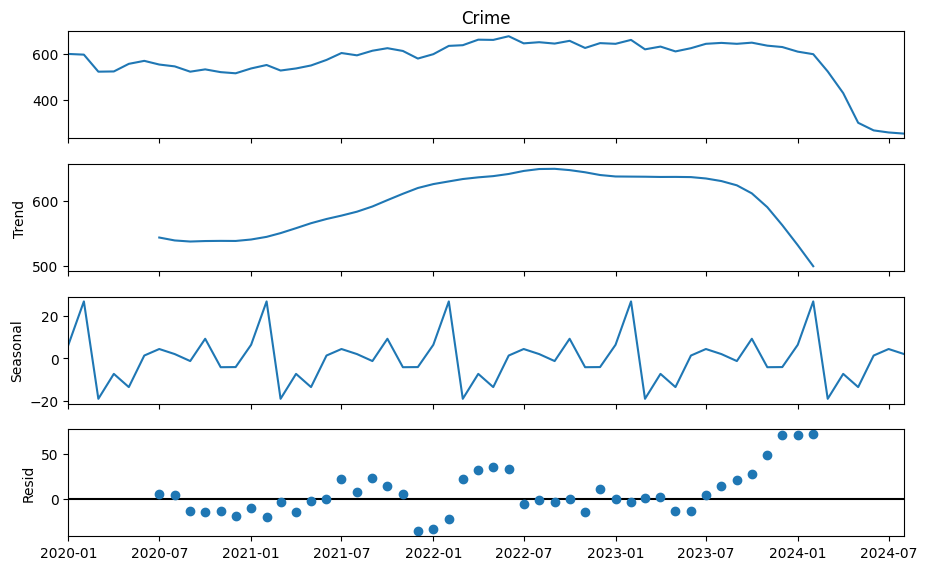

In [20]:
# visualising decomposition
ax = result.plot()
ax.set_size_inches(10,6)

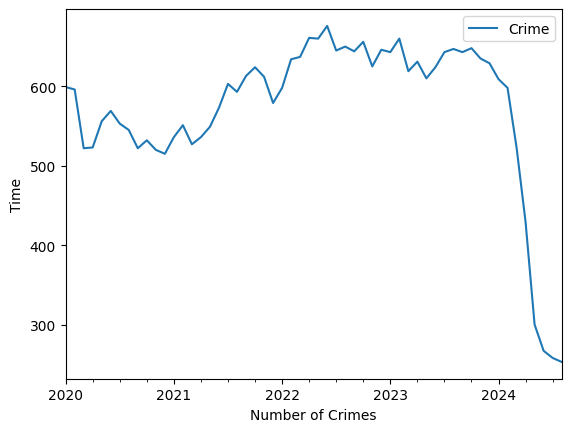

In [21]:
# Fluctuations in number of crime over time
df_crime_copy_1.plot()
plt.xlabel('Number of Crimes')
plt.ylabel('Time')
plt.show()

In [22]:
ADF = adfuller(df_crime_copy_1['Crime'])

In [23]:
print(ADF)

(-1.3306872781370074, 0.6150185606127685, 4, 51, {'1%': -3.5656240522121956, '5%': -2.920142229157715, '10%': -2.598014675124952}, 421.50425517932473)


In [24]:
def ADF_CHECK(time_series):
    result = adfuller(time_series)
    print("Augmented Dickey-Fuller Test")
    labels = ["ADF Test Statistic", "p-value", "Number of Lags Used", "Number of Observations Used"]

    for val, lab in zip(result, labels):
        print(lab + ": " + str(val))
        
    alpha = 0.05
    if result[1] <= alpha:
        print("Reject the null hypothesis")
        print("The data has no unit root and is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("The data has a unit root and is non-stationary")

In [25]:
ADF_CHECK(df_crime_copy_1['Crime'])

Augmented Dickey-Fuller Test
ADF Test Statistic: -1.3306872781370074
p-value: 0.6150185606127685
Number of Lags Used: 4
Number of Observations Used: 51
Fail to reject the null hypothesis
The data has a unit root and is non-stationary


In [26]:
df_crime_copy_1["Difference_1"] = df_crime_copy_1['Crime'] - df_crime_copy_1['Crime'].shift(1)
df_crime_copy_1.dropna(inplace=True)

In [27]:
ADF_CHECK(df_crime_copy_1["Difference_1"])

Augmented Dickey-Fuller Test
ADF Test Statistic: -1.954720111190615
p-value: 0.30677259568633297
Number of Lags Used: 3
Number of Observations Used: 51
Fail to reject the null hypothesis
The data has a unit root and is non-stationary


In [28]:
df_crime_copy_1["Difference_2"] = df_crime_copy_1["Difference_1"] - df_crime_copy_1["Difference_1"].shift(1)
df_crime_copy_1.dropna(inplace=True)

In [29]:
ADF_CHECK(df_crime_copy_1["Difference_2"])

Augmented Dickey-Fuller Test
ADF Test Statistic: -7.200386128765904
p-value: 2.373940183244828e-10
Number of Lags Used: 2
Number of Observations Used: 51
Reject the null hypothesis
The data has no unit root and is stationary


<Axes: xlabel='Date'>

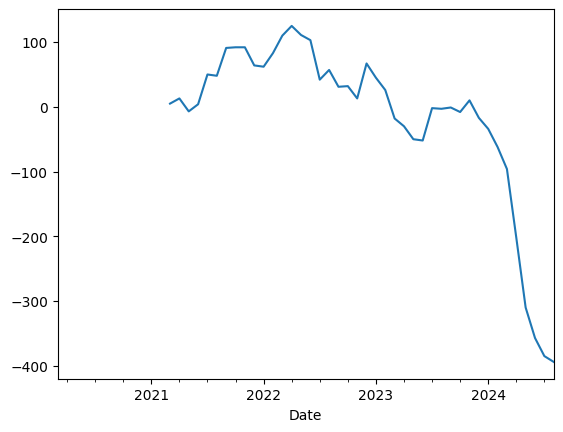

In [30]:
# difference the data and check for stationarity again
df_crime_copy_1['Seasonal Difference'] = df_crime_copy_1['Crime']-df_crime_copy_1['Crime'].shift(12)
df_crime_copy_1["Seasonal Difference"].plot()

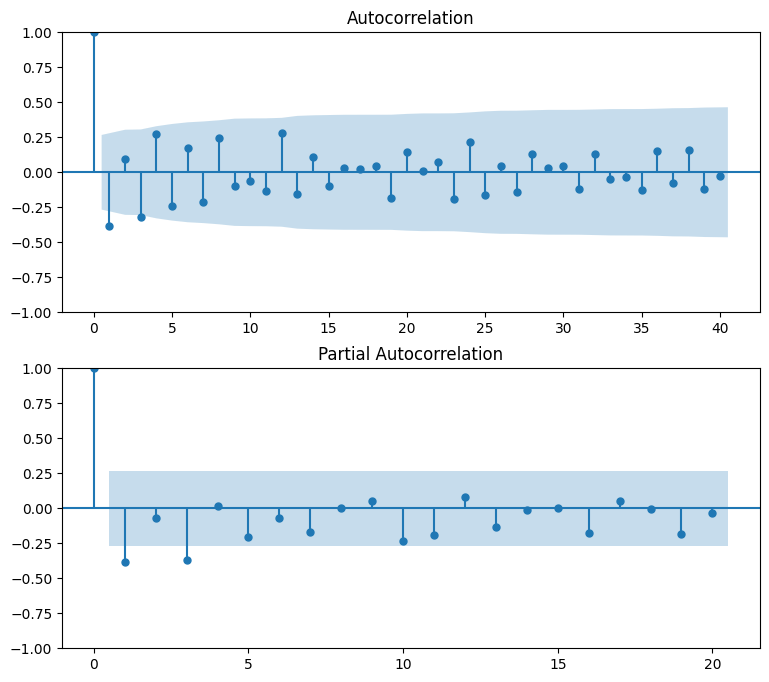

In [31]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(9,8))

ACF = plot_acf(df_crime_copy_1["Difference_2"],lags=40, alpha=0.05, ax=ax1)
PACF = plot_pacf(df_crime_copy_1["Difference_2"],lags=20,alpha=0.05,ax=ax2)
plt.show()

## 2.2. Time Series Forecasting with ARIMA

In [32]:
from statsmodels.tsa.arima.model import ARIMA

In [33]:
ARIMA_model = ARIMA(df_crime_copy_1['Crime'], order=(1, 1, 1))

In [34]:
result_ARIMA = ARIMA_model.fit()

In [35]:
print(result_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                  Crime   No. Observations:                   54
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -248.732
Date:                Fri, 21 Feb 2025   AIC                            503.465
Time:                        16:07:50   BIC                            509.376
Sample:                    03-01-2020   HQIC                           505.738
                         - 08-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6571      0.262      2.509      0.012       0.144       1.170
ma.L1         -0.2449      0.346     -0.708      0.479      -0.923       0.433
sigma2       694.4513    152.896      4.542      0.0

## 2.3. Time Series Forecasting with SARIMA

In [36]:
SARIMA_model = SARIMAX(df_crime_copy_1['Crime'],order = (1,1,1),seasonal_order = (1,1,1,12))

In [37]:
result_SARIMA = SARIMA_model.fit(disp=0)

In [38]:
print(result_SARIMA.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Crime   No. Observations:                   54
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -195.265
Date:                            Fri, 21 Feb 2025   AIC                            400.530
Time:                                    16:07:51   BIC                            409.097
Sample:                                03-01-2020   HQIC                           403.650
                                     - 08-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6718      0.268      2.503      0.012       0.146       1.198
ma.L1         -0.1529      0.360   

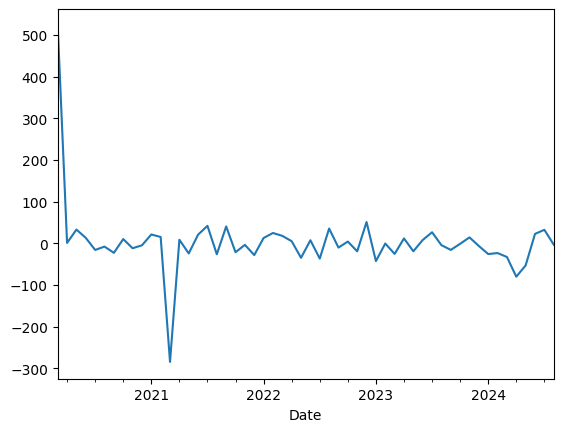

In [39]:
# graphical representation of residuals (goodness of fit)
result_SARIMA.resid.plot()
plt.show();

## 2.4. ARIMA, SARIMA forecast results

<Axes: xlabel='Date'>

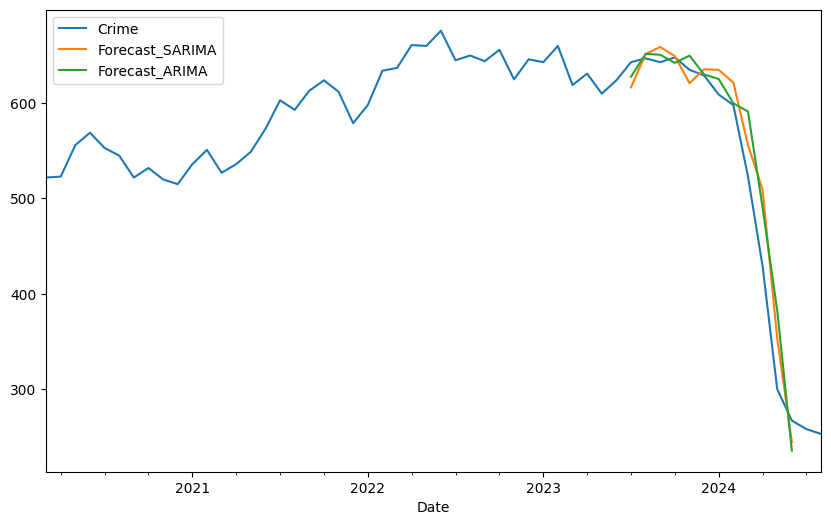

In [40]:

df_crime_copy_1["Forecast_SARIMA"] = result_SARIMA.predict(start=40, end=51)


df_crime_copy_1["Forecast_ARIMA"] = result_ARIMA.predict(start=40, end=51)


df_crime_copy_1[["Crime", "Forecast_SARIMA", "Forecast_ARIMA"]].plot(figsize=(10, 6))


### Generate future dates to predict future crime numbers

In [41]:
from pandas.tseries.offsets import DateOffset
future_dates = [df_crime_copy_1.index[-1] + DateOffset(months = x) for x in range(1,12)]

future_data = pd.DataFrame(index = future_dates,columns = df_crime_copy_1.columns)

final_data = pd.concat([df_crime_copy_1,future_data])
final_data.head()

,Crime,Difference_1,Difference_2,Seasonal Difference,Forecast_SARIMA,Forecast_ARIMA
2020-03-01,522.0,-74.0,-71.0,NaN,NaN,NaN
2020-04-01,523.0,1.0,75.0,NaN,NaN,NaN
2020-05-01,556.0,33.0,32.0,NaN,NaN,NaN
2020-06-01,569.0,13.0,-20.0,NaN,NaN,NaN
2020-07-01,553.0,-16.0,-29.0,NaN,NaN,NaN


In [42]:
print(final_data.shape)

(65, 6)


In [43]:
print(final_data.isnull().sum())

Crime                  11
Difference_1           11
Difference_2           11
Seasonal Difference    23
Forecast_SARIMA        53
Forecast_ARIMA         53
dtype: int64


In [44]:
# forecasting
final_data["Forecast_SARIMA"] = result_SARIMA.predict(start = 51,end = 60)
final_data["Forecast_SARIMA"][51]

244.54435409595533

In [45]:
final_data["Forecast_ARIMA"] = result_ARIMA.predict(start = 51,end = 60)
final_data["Forecast_ARIMA"][51]

235.39014091859644

In [46]:
print(final_data[["Forecast_SARIMA", "Forecast_ARIMA"]].tail(12))

            Forecast_SARIMA  Forecast_ARIMA
2024-08-01       256.269139      247.082714
2024-09-01       240.175487      248.265127
2024-10-01       243.972592      245.153896
2024-11-01       219.354855      243.109541
2024-12-01       226.029111      241.766219
2025-01-01       210.970597      240.883537
2025-02-01       210.098394      240.303536
2025-03-01       146.791246      239.922425
2025-04-01              NaN             NaN
2025-05-01              NaN             NaN
2025-06-01              NaN             NaN
2025-07-01              NaN             NaN


### Future forecasting results with two models ARIMA, SARIMA

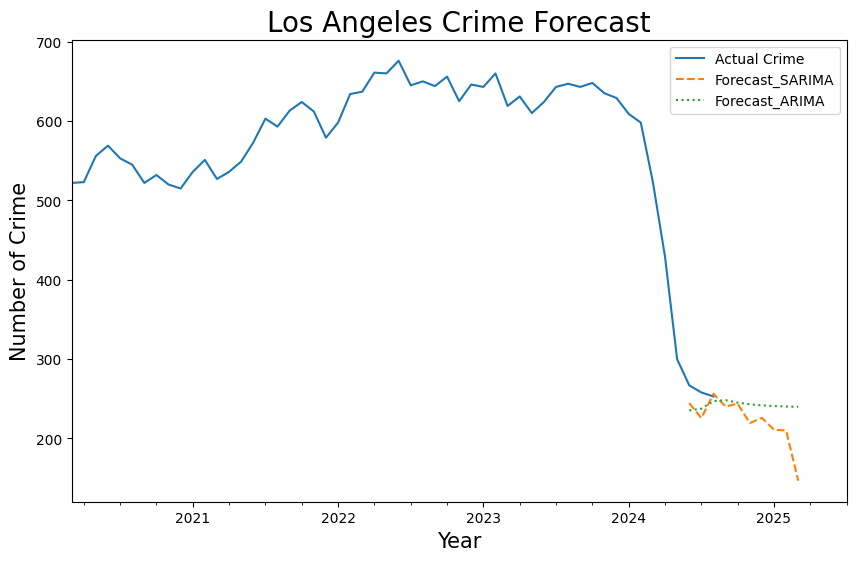

In [47]:

plt.figure(figsize=(10, 6))
final_data["Crime"].plot(label="Actual Crime")
final_data["Forecast_SARIMA"].plot(label="Forecast_SARIMA", linestyle="dashed")
final_data["Forecast_ARIMA"].plot(label="Forecast_ARIMA", linestyle="dotted")


plt.title("Los Angeles Crime Forecast", size=20)
plt.xlabel("Year", size=15)
plt.ylabel("Number of Crime", size=15)
plt.legend()
plt.show()

In [48]:
predicted_ARIMA = result_ARIMA.predict(start=20, end=51)
predicted_SARIMA = result_SARIMA.predict(start=20, end=51)

In [49]:
from sklearn.metrics import mean_squared_error
from math import sqrt
 
actual = df_crime_copy_1['Crime'][22:-1]
predicted_ARIMA = predicted_ARIMA[:-1]
predicted_SARIMA = predicted_SARIMA[:-1]

In [50]:
print("Actual Crime Data Size:", len(actual))
print("Predicted ARIMA Data Size:", len(predicted_ARIMA))
print("Predicted SARIMA Data Size:", len(predicted_SARIMA))

Actual Crime Data Size: 31
Predicted ARIMA Data Size: 31
Predicted SARIMA Data Size: 31


In [51]:
rmse = sqrt(mean_squared_error(actual,predicted_ARIMA))
print('RMSE of ARIMA model:',round(rmse,2))

rmseS = sqrt(mean_squared_error(actual,predicted_SARIMA))
print('RMSE of SARIMA model:',round(rmse,2))

RMSE of ARIMA model: 83.84
RMSE of SARIMA model: 83.84


# 3. Prophet time series forecasting

## 3.1. Data preprocessing

In [52]:
 df_crime_copy_2 = df_crime.copy()

In [53]:
df_crime_copy_2['DATE OCC'] = pd.to_datetime(df_crime_copy_2['DATE OCC'])
df_crime_copy_2['month-year'] = df_crime_copy_2['DATE OCC'].dt.strftime('%m-%Y')

In [54]:
df_crime_copy_2 = df_crime_copy_2.groupby('month-year')['Crm Cd'].count()

In [55]:
df_crime_copy_2 = df_crime_copy_2.to_frame().reset_index()
df_crime_copy_2 = df_crime_copy_2.rename(columns={'month-year':'Date','Crm Cd':'Crime'})
df_crime_copy_2['Date'] = pd.to_datetime(df_crime_copy_2['Date'])
df_crime_copy_2['days_in_month'] = df_crime_copy_2['Date'].dt.days_in_month
df_crime_copy_2.head()

,Date,Crime,days_in_month
0,2020-01-01,18558,31
1,2021-01-01,16619,31
2,2022-01-01,18541,31
3,2023-01-01,19946,31
4,2024-01-01,18870,31


In [56]:
df_crime_copy_2['Crime'] = round((df_crime_copy_2['Crime']/df_crime_copy_2['days_in_month']))
df_crime_copy_2.drop(columns=['days_in_month'],inplace=True)
df_crime_copy_2.tail()

,Date,Crime
52,2023-11-01,635.0
53,2020-12-01,515.0
54,2021-12-01,579.0
55,2022-12-01,646.0
56,2023-12-01,629.0


In [57]:
df_crime_copy_2 = df_crime_copy_2.sort_values(by='Date').reset_index(drop=True)
df_crime_copy_2.set_index('Date',inplace=True)

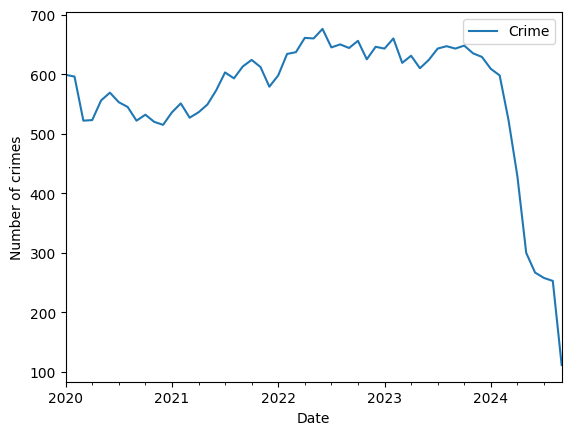

In [58]:
df_crime_copy_2.plot()
plt.ylabel('Number of crimes');

In [59]:
from prophet import Prophet

In [60]:
df_crime_copy_2.reset_index(inplace=True)
df_crime_copy_2.rename(columns={'Date':'ds','Crime':'y'},inplace=True)

In [61]:
# Implementing Prophet time series forecasting
model_Pro = Prophet()
model_Pro.fit(df_crime_copy_2)

16:07:58 - cmdstanpy - INFO - Chain [1] start processing
16:07:59 - cmdstanpy - INFO - Chain [1] done processing


In [62]:
future_dates = model_Pro.make_future_dataframe(periods=12, freq='MS')
future_dates.head()

,ds
0,2020-01-01
1,2020-02-01
2,2020-03-01
3,2020-04-01
4,2020-05-01


In [63]:
forecast = model_Pro.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-01,640.125548,500.626227,784.218220
1,2020-02-01,631.232553,504.524108,771.704564
2,2020-03-01,600.349220,470.392246,740.314720
3,2020-04-01,584.558521,442.896821,718.735208
4,2020-05-01,573.116383,444.191572,700.382996


## 3.2. Future forecasting results with Prophet model

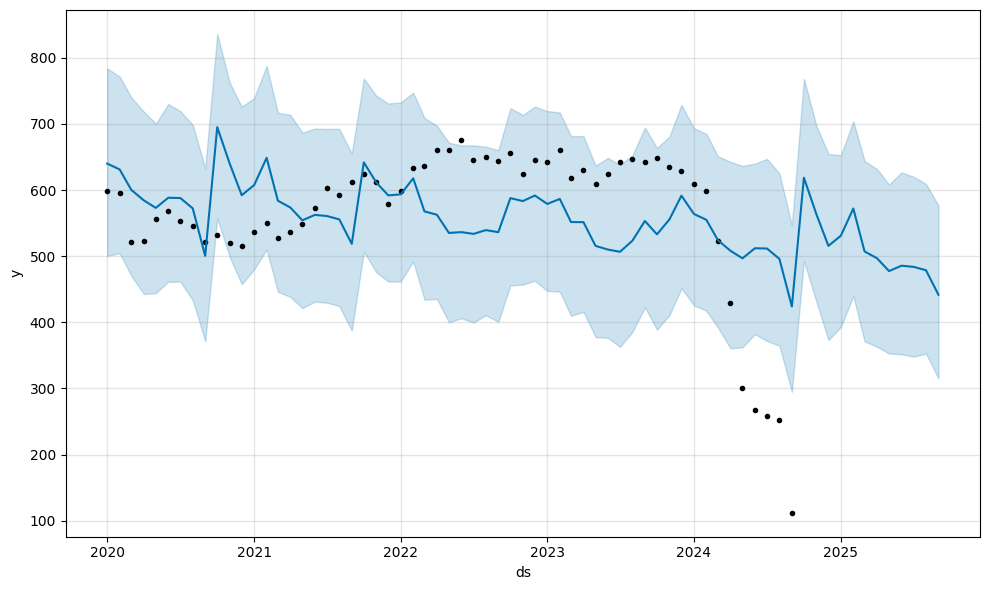

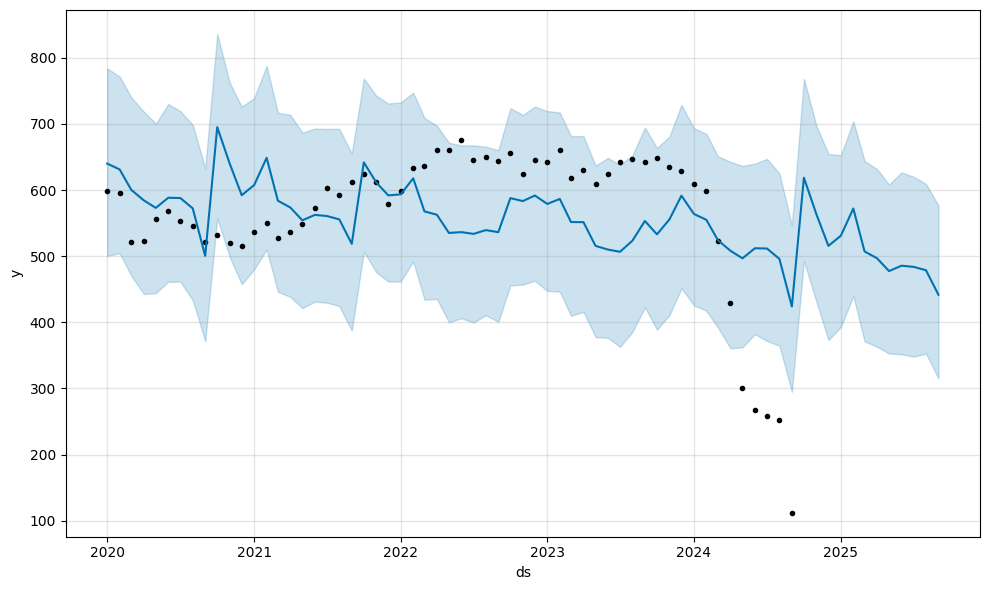

In [64]:
model_Pro.plot(forecast, uncertainty=True)

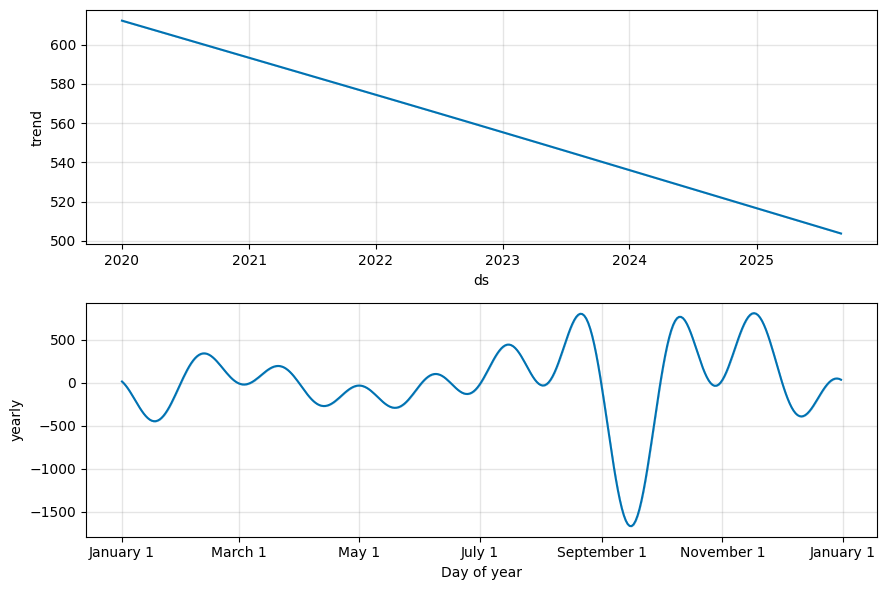

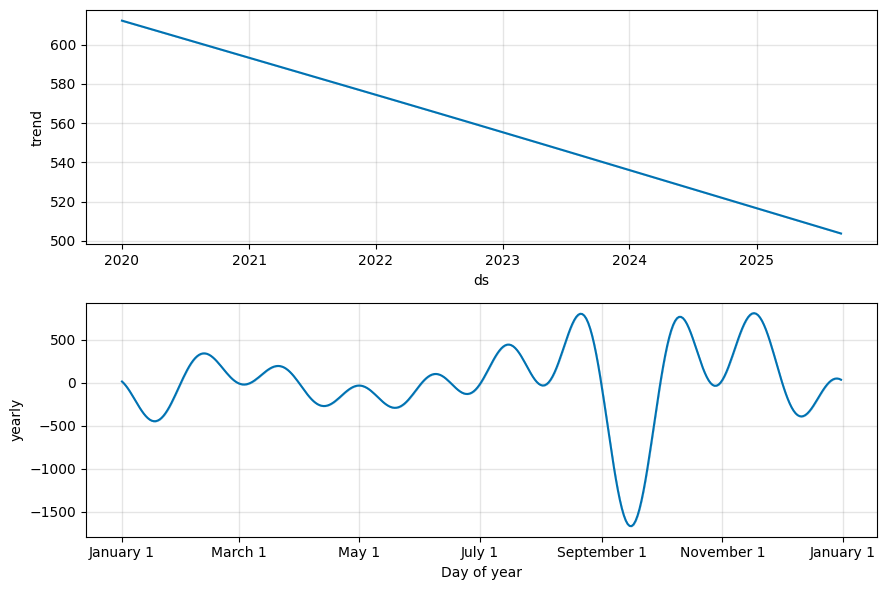

In [65]:
model_Pro.plot_components(forecast)

# ---------------------Thanks everyone-----------------------